In [1]:
import cv2
import seaborn as sns
import numpy as np
from PIL import Image
from skimage.morphology import binary_opening, binary_closing
from skimage.morphology import dilation
from scipy import ndimage as ndi
from skimage import io
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import configparser as conf
import tensorflow as tf
import segmentation_models as sm
import os
from tiff import Tiff
from pathlib import Path as P
from roimaker import segment_image, quick_segment
sm.set_framework('tf.keras')

/home/nathan/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


Segmentation Models: using `keras` framework.


In [2]:
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data

In [3]:
# GLOBALS
ROOT = "/media/nathan/KINGSTON/Data3DModelling/density/"
FILE = "/media/nathan/KINGSTON/Data3DModelling/density/x63_captures_DAPI_KI67.lif - DAPI_unzoom.tif"
EXT = ".tif"
MODELPATH = "/home/nathan/Desktop/data/dl_data/best/generator.h5"
REFCHANNEL = None

## Load images

In [4]:
img = Tiff(FILE)
img.get_imagej_metadata()

{'ImageJ': '1.53c',
 'images': '40',
 'slices': '40',
 'unit': 'micron',
 'spacing': '0.3952',
 'loop': 'false'}

## Create masks

In [5]:
model = sm.Unet("efficientnetb0", activation="softmax",
                input_shape=(224, 224, 3), encoder_weights='imagenet',
               classes=3)
model.load_weights(MODELPATH)

In [6]:
def segment(model, tiff, z=0):
    tiff.seek_z_only(z=z)
    return quick_segment(model, tiff.img)

In [7]:
if not os.path.exists(P(ROOT) / "mask_x63_unzoom.npy"):
    print("Computing masks")
    ls_mask = [segment(model, img, z) for z in tqdm(range(img.get_z()))]
    masks = np.array(ls_mask)
    masks.shape
    # save masks
    np.save(P(ROOT) / "mask_x63_unzoom.npy", masks)
else:
    print("Loading masks")
    masks = np.load(P(ROOT) / "mask_x63_unzoom.npy")

Loading masks


## Test 2D watershed

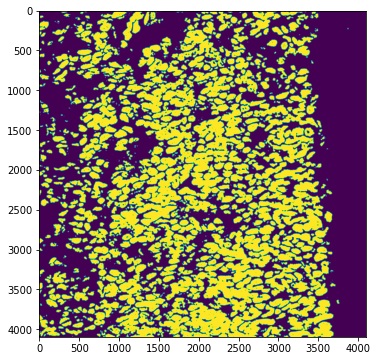

In [8]:
plt.figure(figsize=(6, 6))
plt.imshow(masks[20])

In [9]:
# original data
img.seek_z_only(z=20)
original_image = np.asarray(img.img)
original_mask = masks[20].astype(np.uint8)

In [19]:
# library
def preprocess(mask):
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations = 2)
    opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
    return opening

def make_bg(prepro_mask):
    kernel = np.ones((3,3), np.uint8)
    return cv2.dilate(prepro_mask, kernel, iterations=5)

def make_dist_transform(prepro_mask):
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(prepro_mask, cv2.DIST_L2, 5)
    return dist_transform

def make_markers(dist_transform, background):
    kernel = np.ones((3,3), np.uint8)
    dist = cv2.dilate(dist_transform, kernel, iterations=7)
    n_dist, n_dist_t = np.asarray(dist), np.asarray(dist_transform)
    sure_fg = (n_dist_t > (0.2 * n_dist_t.max())) & (n_dist_t > (0.90 * n_dist))

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    sure_fg = cv2.dilate(sure_fg, kernel, iterations=5)
    unknown = cv2.subtract(background, sure_fg)
    
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    markers[unknown == 1] = 0
    
    return markers

def preprocess_3(mask):
    # kernel = np.ones((3,3), np.uint8)
    # opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations = 2)
    # opening = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
    opening = binary_opening(binary_opening(mask))
    res = binary_closing(binary_closing(opening))
    return res

def make_bg_3(prepro_mask):
    prepro_mask = prepro_mask.copy()
    kernel = np.ones((3,3), np.uint8)
    for i in range(5):
        prepro_mask = dilation(prepro_mask)
    return prepro_mask

def make_dist_transform_3(prepro_mask):
    # Finding sure foreground area
    dist_transform = ndi.distance_transform_edt(prepro_mask)
    return dist_transform

def make_markers_3(dist_transform, background, rat1=0.2, rat2=0.9):
    kernel = np.ones((3,) * dist_transform.ndim, np.uint8)
    dist = dist_transform.copy()
    
    # dist = cv2.dilate(dist_transform, kernel, iterations=7)
    
    for i in range(7):
        dist = dilation(dist, kernel)
    
    n_dist, n_dist_t = np.asarray(dist), np.asarray(dist_transform)
    sure_fg = (n_dist_t > (rat1 * n_dist_t.max())) & (n_dist_t > (rat2 * n_dist))

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    
    # sure_fg = cv2.dilate(sure_fg, kernel, iterations=5)
    
    for i in range(5):
        sure_fg = dilation(sure_fg, kernel)
    
    unknown = np.clip(background - sure_fg, 0, 1)
    
    markers, _ = ndi.label(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1
    markers[unknown == 1] = 0
    
    return markers

def my_watershed(dist, markers):
    return watershed(-dist, markers.copy())

def get_borders(labels):
    return sobel(labels) > 0

def show_all(a, b, c, d, window=(slice(3000, 3500), slice(3000, 3500))):
    plt.figure(figsize=(14, 14))
    plt.subplot(2, 2, 1)
    plt.imshow(a[window])
    plt.subplot(2, 2, 2)
    plt.imshow(b[window])
    plt.subplot(2, 2, 3)
    plt.imshow(c[window])
    plt.subplot(2, 2, 4)
    plt.imshow(d[window])
    
def show_all_3(a, b, c, d, window=(slice(None, None), slice(None, None))):
    plt.figure(figsize=(14, 14))
    plt.subplot(2, 2, 1)
    plt.imshow(a[window])
    plt.subplot(2, 2, 2)
    plt.imshow(b[window])
    plt.subplot(2, 2, 3)
    plt.imshow(c[window])
    plt.subplot(2, 2, 4)
    plt.imshow(d[window])

In [29]:
# begin
img.seek_z_only(z=20)
image = np.asarray(img.img)
mask = masks[20].astype(np.uint8)

In [31]:
def three(x):
    return np.repeat(x[np.newaxis, ...], 2, axis=0)

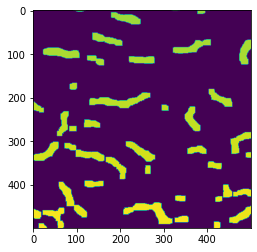

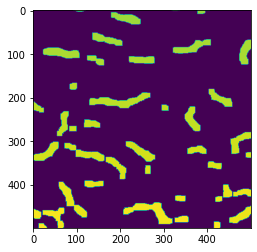

In [107]:
prepro_mask = preprocess_3(mask).astype(np.uint8)
bg = make_bg_3(prepro_mask).astype(np.uint8)
dist_transform = make_dist_transform_3(prepro_mask).astype(np.uint8)
markers = make_markers_3(dist_transform, bg).astype(np.uint8)
X = my_watershed(dist_transform, markers)
X_3 = make_markers_3(dist_transform, bg)
plt.imshow(X[3000:3500, 3000:3500])
plt.figure()
plt.imshow(X_3[3000:3500, 3000:3500])

In [ ]:
labels = my_watershed(dist_transform, markers)

borders = get_borders(labels)

show_all(labels, markers, prepro_mask, borders)

In [109]:
a = np.zeros((1, 3, 5))
np.repeat(a, 7, axis=0).shape

(7, 3, 5)

In [17]:
def show_watershed(mask, image):
    prepro_mask = preprocess(mask)

    background = make_bg(prepro_mask)

    dist_transform = make_dist_transform(prepro_mask)

    markers = make_markers(dist_transform, background)

    labels = my_watershed(dist_transform, markers)

    borders = get_borders(labels)

    show_all(labels, markers, prepro_mask, borders)

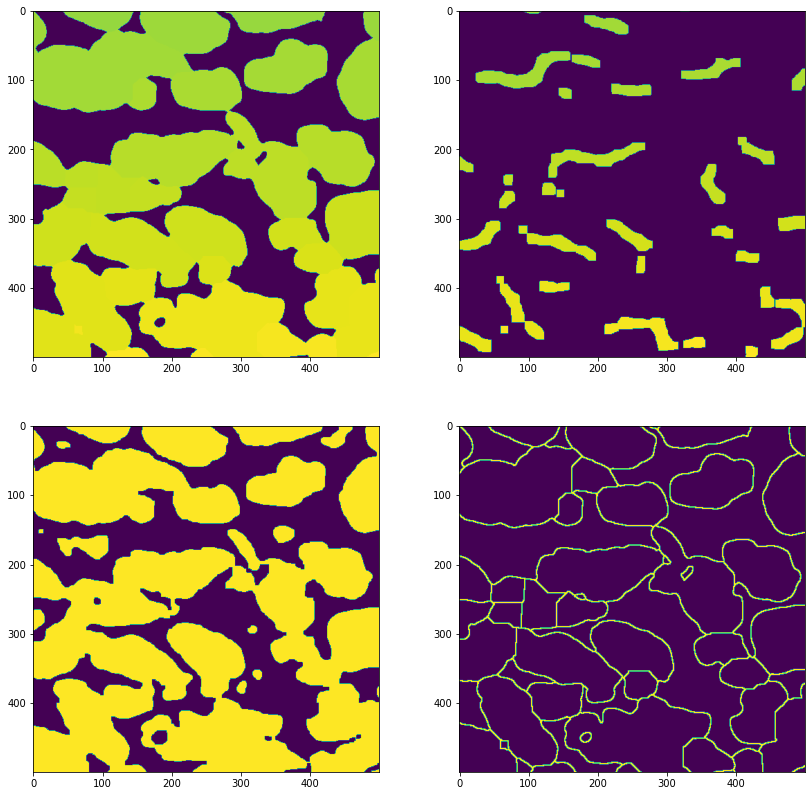

In [60]:
# begin
img.seek_z_only(z=20)
image = np.asarray(img.img)
mask = masks[20].astype(np.uint8)

prepro_mask = preprocess(mask)

background = make_bg(prepro_mask)

dist_transform = make_dist_transform(prepro_mask)

markers = make_markers(dist_transform, background)

labels = my_watershed(dist_transform, markers)

borders = get_borders(labels)

show_all(labels, markers, prepro_mask, borders)

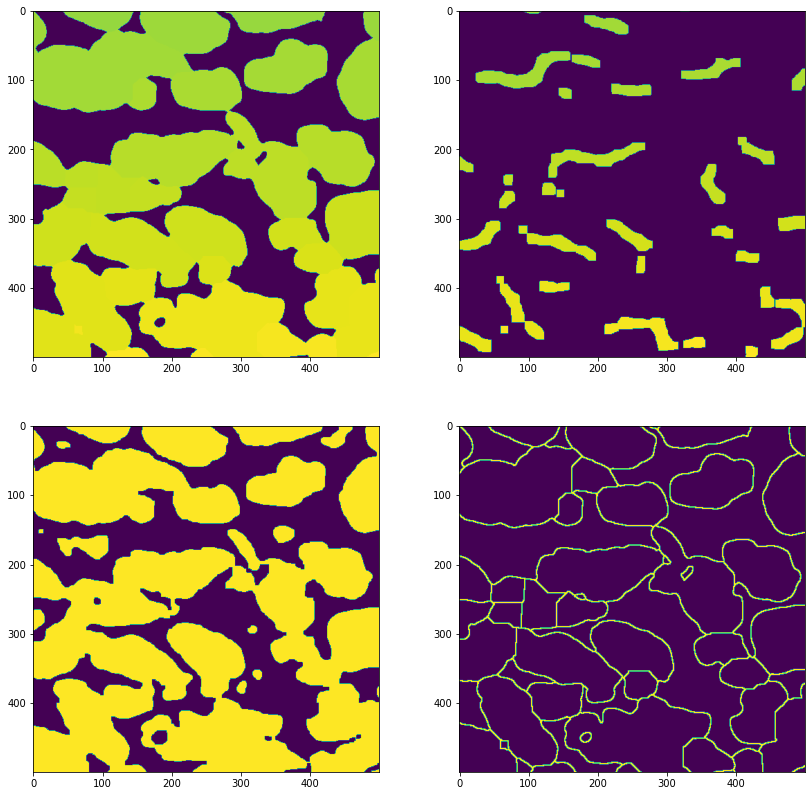

In [23]:
img.seek_z_only(z=20)
image = np.asarray(img.img)
mask = masks[20].astype(np.uint8)
show_watershed(mask, image)

In [62]:
def show_watershed_3(stack_mask, stack_image, repeat=1, id_show=20):
    prepro_mask = preprocess_3(stack_mask)
    
    # repeat N times
    prepro_mask = np.repeat(prepro_mask, repeat, axis=0)
    
    bg = make_bg_3(prepro_mask)
    dist_transform = make_dist_transform_3(prepro_mask)
    markers = make_markers_3(dist_transform, bg)
    labels = my_watershed(dist_transform, markers)
    borders = get_borders(labels)
    
    index = id_show * repeat
    print(labels.shape, markers.shape, prepro_mask.shape, borders.shape)
    show_all_3(labels[index], markers[index], prepro_mask[index], borders[index])
    
def get_watershed_3(stack_mask, stack_image, repeat=1, id_show=20):
    prepro_mask = preprocess_3(stack_mask)
    
    # repeat N times
    prepro_mask = np.repeat(prepro_mask, repeat, axis=0)
    
    bg = make_bg_3(prepro_mask)
    dist_transform = make_dist_transform_3(prepro_mask)
    markers = make_markers_3(dist_transform, bg)
    labels = my_watershed(dist_transform, markers)
    borders = get_borders(labels)
    
    index = id_show * repeat
    return labels

In [12]:
masks.shape

(40, 4096, 4096)

In [21]:
tiny_masks = masks[:, 3000:3500, 3000:3500]

(240, 500, 500) (240, 500, 500) (240, 500, 500) (240, 500, 500)


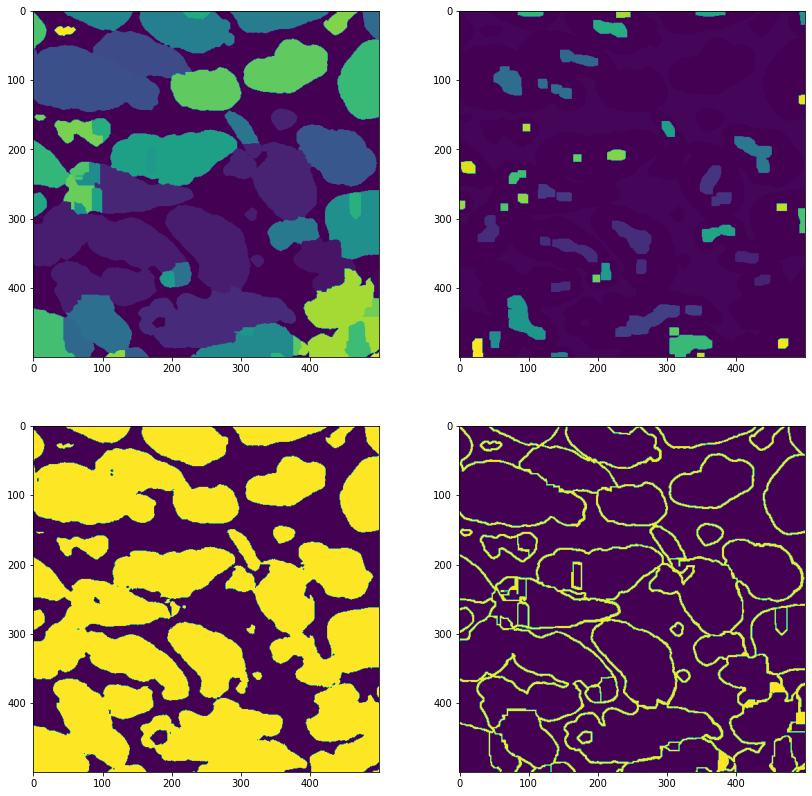

In [24]:
show_watershed_3(tiny_masks, None, repeat=6)

#### exploded view

Pick a sligthly larger image (2 at most)  
For all label, individually recompute position, then copy  
Export all in folder  

In imageJ  
Load all  
Reduce a bit resolution  
Show in 3D  

In [54]:
test_label = np.array([
    [
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 0],
    ]
])

In [52]:
a = np.array([0, 0, 0, 0])
a[1:1+2] |= np.array([1, 0])
a

array([0, 1, 0, 0])

In [68]:
def explode(labels):
    a, b, c = labels.shape
    final_image = np.zeros((2 * a, 2 * b, 2 * c), dtype=np.bool)
    
    id_label = set(np.unique(labels))
    id_label = id_label - ({0} if 0 in id_label else {1})
    for i_l in id_label:
        x = (labels == i_l)
        com = ndi.measurements.center_of_mass(x)
        c_a, c_b, c_c = int(com[0]), int(com[1]), int(com[2])
        print(com)
        
        # compute position
        final_image[c_a:c_a + a, c_b:c_b + b, c_c:c_c + c] |= x
    return final_image

In [69]:
explode(test_label)

(0.0, 0.5, 1.0)
(1.0, 1.5, 2.0)


array([[[False, False,  True, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]],

       [[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        

In [63]:
labels_3 = get_watershed_3(tiny_masks, None, repeat=6)

In [67]:
np.unique(labels_3)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int32)

In [70]:
exploded_masks = explode(labels_3)

(93.12893160020676, 403.82160154679633, 492.2507226678408)
(76.02828668616101, 235.34630303753656, 356.044220325834)
(77.86381455073001, 283.2820014198846, 486.7353767324135)
(98.0099431322611, 362.17216446289643, 420.3995569200712)
(71.37071244883914, 263.43565504002316, 358.75504364518815)
(172.90167451553395, 343.54847000779824, 185.96855397426202)
(170.63794814462088, 195.12377797561126, 354.10671322654923)
(103.86609807349332, 260.8447089806946, 145.2379009981913)
(146.47047916504434, 439.9568624479714, 272.104542740826)
(90.26700880782302, 237.99216311810804, 493.84506553852555)
(82.03973009446693, 60.21608636977058, 163.4532253711201)
(83.01447258558308, 432.83384358474814, 280.80656832730307)
(85.70353434314566, 449.2484519386491, 4.279317900352481)
(86.22293951509371, 36.29978358948025, 270.6182004915086)
(83.94789640700174, 199.71906029276283, 236.37421946975127)
(87.7888369711323, 377.8497727709147, 388.4013313704154)
(130.25341320298844, 62.821945598076, 152.8700032289312)


In [65]:
dest = "/home/nathan/Desktop/data/cellsegmentation/export_mask_watershed"

def export_masks(masks, dest, repeat=1):
    idx = 0
    for mask in masks:
        for i in range(repeat):
            Image.fromarray((mask * 255).astype(np.uint8)).save(str(P(dest) / f"mask_{idx}.png"))
            idx += 1

In [71]:
export_masks(exploded_masks, dest)